In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FlightWeatherAnalysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/10 18:00:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("hdfs://localhost:9000/user/ketkimaddiwar/airline_data/2024_*.csv")

df.show(5)
df.printSchema()
df.count()

25/05/10 18:00:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/05/10 18:00:28 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Year, Quarter, Month, DayofMonth, DayOfWeek, FlightDate, Reporting_Airline, DOT_ID_Reporting_Airline, IATA_CODE_Reporting_Airline, Tail_Number, Flight_Number_Reporting_Airline, OriginAirportID, OriginAirportSeqID, OriginCityMarketID, Origin, OriginCityName, OriginState, OriginStateFips, OriginStateName, OriginWac, DestAirportID, DestAirportSeqID, DestCityMarketID, Dest, DestCityName, DestState, DestStateFips, DestStateName, DestWac, CRSDepTime, DepTime, DepDelay, DepDelayMinutes, DepDel15, DepartureDelayGroups, DepTimeBlk, TaxiOut, WheelsOff, WheelsOn, TaxiIn, CRSArrTime, ArrTime, ArrDelay, ArrDelayMinutes, ArrDel15, ArrivalDelayGroups, ArrTimeBlk, Cancelled, CancellationCode, Diverted, CRSElapsedTime, Actual

+----+-------+-----+----------+---------+----------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+----+------------+---------+-------------+-------------+-------+----------+-------+--------+---------------+--------+--------------------+----------+-------+---------+--------+------+----------+-------+--------+---------------+--------+------------------+----------+---------+----------------+--------+--------------+-----------------+-------+-------+--------+-------------+------------+------------+--------+-------------+-----------------+------------+-------------+---------------+------------------+--------------+--------------------+-----------+-----------+-----------+-------------+----------------+------------+--------------+----------------+----

7079061

In [3]:
from pyspark.sql.functions import col
df.select("FlightDate", "Origin","Reporting_Airline", "Dest", "ArrDelay","DepDelay").show(20, truncate=False)
df

+----------+------+-----------------+----+--------+--------+
|FlightDate|Origin|Reporting_Airline|Dest|ArrDelay|DepDelay|
+----------+------+-----------------+----+--------+--------+
|2024-06-07|CHS   |9E               |JFK |-19.0   |-10.0   |
|2024-06-08|CHS   |9E               |JFK |-11.0   |-6.0    |
|2024-06-09|CHS   |9E               |JFK |-12.0   |-4.0    |
|2024-06-10|CHS   |9E               |JFK |200.0   |223.0   |
|2024-06-11|CHS   |9E               |JFK |-13.0   |-3.0    |
|2024-06-12|CHS   |9E               |JFK |-18.0   |-2.0    |
|2024-06-13|CHS   |9E               |JFK |726.0   |677.0   |
|2024-06-14|CHS   |9E               |JFK |-12.0   |-1.0    |
|2024-06-15|CHS   |9E               |JFK |-8.0    |-1.0    |
|2024-06-16|CHS   |9E               |JFK |-16.0   |-2.0    |
|2024-06-17|CHS   |9E               |JFK |-12.0   |-1.0    |
|2024-06-18|CHS   |9E               |JFK |2.0     |6.0     |
|2024-06-19|CHS   |9E               |JFK |-5.0    |-8.0    |
|2024-06-20|CHS   |9E   

DataFrame[Year: int, Quarter: int, Month: int, DayofMonth: int, DayOfWeek: int, FlightDate: date, Reporting_Airline: string, DOT_ID_Reporting_Airline: int, IATA_CODE_Reporting_Airline: string, Tail_Number: string, Flight_Number_Reporting_Airline: int, OriginAirportID: int, OriginAirportSeqID: int, OriginCityMarketID: int, Origin: string, OriginCityName: string, OriginState: string, OriginStateFips: int, OriginStateName: string, OriginWac: int, DestAirportID: int, DestAirportSeqID: int, DestCityMarketID: int, Dest: string, DestCityName: string, DestState: string, DestStateFips: int, DestStateName: string, DestWac: int, CRSDepTime: int, DepTime: int, DepDelay: double, DepDelayMinutes: double, DepDel15: double, DepartureDelayGroups: int, DepTimeBlk: string, TaxiOut: double, WheelsOff: int, WheelsOn: int, TaxiIn: double, CRSArrTime: int, ArrTime: int, ArrDelay: double, ArrDelayMinutes: double, ArrDel15: double, ArrivalDelayGroups: int, ArrTimeBlk: string, Cancelled: double, CancellationCod

In [3]:
import pandas as pd

# Load airport info
airports_df = pd.read_csv("airports.csv")

# Filter valid IATA codes only
airports_df = airports_df[airports_df["iata_code"].notnull()]

# Build IATA → (lat, lon) mapping
iata_coords = dict(zip(
    airports_df["iata_code"],
    zip(airports_df["latitude_deg"], airports_df["longitude_deg"])
))

# Sample output
print("Example:", {k: iata_coords[k] for k in list(iata_coords)[:5]})


Example: {'UTK': (11.222219, 169.851429), 'OCA': (25.325399398804, -80.274803161621), 'CUX': (27.7211, -97.512802), 'CSE': (38.851918, -106.928341), 'CUS': (31.823898, -107.629924)}


In [6]:
# Extract all unique IATA airport codes involved in weather-delayed flights
from pyspark.sql.functions import col, to_date

# Convert date column
df = df.withColumn("FlightDate", to_date(col("FlightDate"), "yyyy-MM-dd"))

# Extract unique IATA codes
airport_codes = df.select("Origin").union(df.select("Dest")) \
    .distinct().rdd.flatMap(lambda x: x).collect()

print("Airports codes", airport_codes)

Airports codes ['BGM', 'DLG', 'PSE', 'MSY', 'PPG', 'GEG', 'SNA', 'BUR', 'GRB', 'GTF', 'IDA', 'GRR', 'PVU', 'EUG', 'PSG', 'GSO', 'MYR', 'PVD', 'OAK', 'MQT', 'MSN', 'FAR', 'FSM', 'SCC', 'DCA', 'RFD', 'GTR', 'MLU', 'CID', 'WRG', 'IAG', 'LEX', 'RDM', 'ORF', 'EVV', 'KTN', 'CWA', 'SAV', 'GCK', 'TRI', 'CDV', 'CMH', 'ADK', 'CAK', 'CHO', 'MOB', 'PNS', 'LIH', 'IAH', 'HNL', 'SHV', 'GST', 'CVG', 'SJC', 'TOL', 'LGA', 'BUF', 'TLH', 'ACT', 'HPN', 'MLI', 'AUS', 'SJU', 'ATW', 'DHN', 'AVL', 'LGB', 'GJT', 'BFL', 'GFK', 'SRQ', 'RNO', 'EYW', 'SBN', 'TTN', 'RST', 'JAC', 'CHS', 'HGR', 'TUL', 'RSW', 'HRL', 'ISP', 'AMA', 'BOS', 'MLB', 'MAF', 'EWR', 'LAS', 'BIS', 'FAI', 'JAN', 'ITO', 'XNA', 'HHH', 'DLH', 'HYA', 'DEN', 'ALB', 'OME', 'GRI', 'SBA', 'PSP', 'IAD', 'BOI', 'DRO', 'BRO', 'BMI', 'SEA', 'CMI', 'PBG', 'LRD', 'VLD', 'PSM', 'MCI', 'GRK', 'CLT', 'TVC', 'BNA', 'PAE', 'CLL', 'PSC', 'BLI', 'ORH', 'ABQ', 'PBI', 'PIE', 'SDF', 'SCK', 'BDL', 'ITH', 'MRY', 'DAL', 'USA', 'CLE', 'PDX', 'ACK', 'MIA', 'MFR', 'BWI', 'TPA

In [7]:
from meteostat import Stations, Hourly
from datetime import datetime
import pandas as pd

start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)

weather_dataframes = []

def fetch_full_hourly_weather(iata_code, start, end):
    if iata_code not in iata_coords:
        return pd.DataFrame()

    lat, lon = iata_coords[iata_code]
    stations = Stations().nearby(lat, lon).fetch(5)

    for i in range(len(stations)):
        station_id = stations.index[i]
        h_start = pd.to_datetime(stations.iloc[i]['hourly_start'])
        h_end = pd.to_datetime(stations.iloc[i]['hourly_end'])

        if start >= h_start and end <= h_end:
            try:
                df = Hourly(station_id, start, end).fetch()
                if df.empty:
                    continue
                df = df.reset_index()
                df["Airport"] = iata_code
                df["StationID"] = station_id
                df.rename(columns={"time": "WeatherDate"}, inplace=True)
                return df[["WeatherDate", "Airport", "temp", "wspd", "prcp", "rhum"]]
            except:
                continue
    return pd.DataFrame()

# Now use it like before
for code in airport_codes:
    print(f"📡 Fetching weather for {code}...")
    wdf = fetch_full_hourly_weather(code, start, end)
    if not wdf.empty:
        weather_dataframes.append(wdf)
        print(f"{code}: {len(wdf)} records")
    else:
        print(f"⚠️ No data for {code}")


📡 Fetching weather for BGM...
BGM: 8553 records
📡 Fetching weather for DLG...
DLG: 8760 records
📡 Fetching weather for PSE...
PSE: 8758 records
📡 Fetching weather for MSY...
MSY: 8761 records
📡 Fetching weather for PPG...
PPG: 8761 records
📡 Fetching weather for GEG...
GEG: 8761 records
📡 Fetching weather for SNA...
SNA: 8760 records
📡 Fetching weather for BUR...
BUR: 8761 records
📡 Fetching weather for GRB...
GRB: 8761 records
📡 Fetching weather for GTF...
GTF: 8761 records
📡 Fetching weather for IDA...
IDA: 8761 records
📡 Fetching weather for GRR...
GRR: 8761 records
📡 Fetching weather for PVU...
PVU: 8760 records
📡 Fetching weather for EUG...
EUG: 8761 records
📡 Fetching weather for PSG...
PSG: 8758 records
📡 Fetching weather for GSO...
GSO: 8761 records
📡 Fetching weather for MYR...
MYR: 8754 records
📡 Fetching weather for PVD...
PVD: 8760 records
📡 Fetching weather for OAK...
OAK: 8761 records
📡 Fetching weather for MQT...
MQT: 8626 records
📡 Fetching weather for MSN...
MSN: 8553 

MEM: 8761 records
📡 Fetching weather for SAF...
SAF: 8761 records
📡 Fetching weather for ELP...
ELP: 8761 records
📡 Fetching weather for BHM...
BHM: 8761 records
📡 Fetching weather for ATL...
ATL: 8761 records
📡 Fetching weather for FLL...
FLL: 8761 records
📡 Fetching weather for FNT...
FNT: 8721 records
📡 Fetching weather for AZA...
AZA: 8689 records
📡 Fetching weather for RIC...
RIC: 8761 records
📡 Fetching weather for AKN...
AKN: 8748 records
📡 Fetching weather for LCK...
LCK: 8759 records
📡 Fetching weather for DAY...
DAY: 8761 records
📡 Fetching weather for OMA...
OMA: 8761 records
📡 Fetching weather for SJT...
SJT: 8757 records
📡 Fetching weather for LCH...
LCH: 8563 records
📡 Fetching weather for STC...
STC: 8761 records
📡 Fetching weather for VPS...
VPS: 8759 records
📡 Fetching weather for MHK...
MHK: 8761 records
📡 Fetching weather for LIT...
LIT: 8563 records
📡 Fetching weather for MVY...
MVY: 8761 records
📡 Fetching weather for CAE...
CAE: 8761 records
📡 Fetching weather for

PQI: 8751 records
📡 Fetching weather for BIH...
BIH: 8761 records
📡 Fetching weather for EAR...
EAR: 8760 records
📡 Fetching weather for EWN...
EWN: 8760 records
📡 Fetching weather for MGW...
MGW: 8761 records
📡 Fetching weather for EAU...
EAU: 8761 records
📡 Fetching weather for CNY...
CNY: 8761 records
📡 Fetching weather for VEL...
VEL: 8761 records


In [8]:
df = df.withColumn("FlightDate", to_date(col("FlightDate"), "yyyy-MM-dd"))

In [9]:
weather_df = pd.concat(weather_dataframes, ignore_index=True)
weather_df

,WeatherDate,Airport,temp,wspd,prcp,rhum
0,2024-01-01 00:00:00,BGM,0.0,6.0,0.0,86.0
1,2024-01-01 01:00:00,BGM,0.0,4.3,0.0,93.0
2,2024-01-01 02:00:00,BGM,0.0,6.0,0.0,93.0
3,2024-01-01 03:00:00,BGM,0.0,6.1,0.0,93.0
4,2024-01-01 04:00:00,BGM,0.0,4.7,0.1,93.0
...,...,...,...,...,...,...
3040726,2024-12-30 20:00:00,VEL,1.1,5.4,0.0,79.0
3040727,2024-12-30 21:00:00,VEL,2.8,7.6,0.0,64.0
3040728,2024-12-30 22:00:00,VEL,2.8,9.4,0.0,59.0
3040729,2024-12-30 23:00:00,VEL,1.1,7.6,0.0,67.0


In [10]:
weather_df["Date"] = pd.to_datetime(weather_df["WeatherDate"]).dt.date
weather_df["Hour"] = pd.to_datetime(weather_df["WeatherDate"]).dt.hour
weather_df

,WeatherDate,Airport,temp,wspd,prcp,rhum,Date,Hour
0,2024-01-01 00:00:00,BGM,0.0,6.0,0.0,86.0,2024-01-01,0
1,2024-01-01 01:00:00,BGM,0.0,4.3,0.0,93.0,2024-01-01,1
2,2024-01-01 02:00:00,BGM,0.0,6.0,0.0,93.0,2024-01-01,2
3,2024-01-01 03:00:00,BGM,0.0,6.1,0.0,93.0,2024-01-01,3
4,2024-01-01 04:00:00,BGM,0.0,4.7,0.1,93.0,2024-01-01,4
...,...,...,...,...,...,...,...,...
3040726,2024-12-30 20:00:00,VEL,1.1,5.4,0.0,79.0,2024-12-30,20
3040727,2024-12-30 21:00:00,VEL,2.8,7.6,0.0,64.0,2024-12-30,21
3040728,2024-12-30 22:00:00,VEL,2.8,9.4,0.0,59.0,2024-12-30,22
3040729,2024-12-30 23:00:00,VEL,1.1,7.6,0.0,67.0,2024-12-30,23


In [11]:
from pyspark.sql.functions import floor, col, hour, to_date

df = df.withColumn("DepHour", floor(col("DepTime") / 100))
df = df.withColumn("ArrHour", floor(col("ArrTime") / 100))
df = df.withColumn("Date", to_date(col("FlightDate"), "yyyy-MM-dd"))

In [12]:
df_flight_filtered = df.select(
    "Date", "DepHour", "ArrHour", "Origin", "Dest",
    "FlightDate", "DepTime", "ArrTime", "DepDelay", "ArrDelay"
)

In [13]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType, DateType, IntegerType, TimestampType

weather_schema = StructType([
    StructField("WeatherDate",     TimestampType(), True),
    StructField("Airport",         StringType(),    True),
    StructField("temp",            FloatType(),     True),
    StructField("wspd",            FloatType(),     True),
    StructField("prcp",            FloatType(),     True),
    StructField("rhum",            FloatType(),     True),
    StructField("Date",            DateType(),      True),
    StructField("Hour",            IntegerType(),   True),
])

# Make sure weather_df (Pandas DataFrame) exists and is populated
# Convert WeatherDate to UTC datetime format to prevent timezone issues
weather_df["WeatherDate"] = pd.to_datetime(weather_df["WeatherDate"], utc=True)

# Convert to Spark DataFrame
weather_spark_df = spark.createDataFrame(weather_df, schema=weather_schema)


In [14]:
joined_df = df_flight_filtered.join(
    weather_spark_df,
    (df_flight_filtered["Date"] == weather_spark_df["Date"]) &
    (df_flight_filtered["DepHour"] == weather_spark_df["Hour"]) &
    (df_flight_filtered["Origin"] == weather_spark_df["Airport"]),
    how="left"
).drop(weather_spark_df["Date"]).drop(weather_spark_df["Hour"]).drop(weather_spark_df["Airport"])


In [15]:
joined_df = joined_df.withColumnRenamed("temp", "origin_temp") \
    .withColumnRenamed("wspd", "origin_wspd") \
    .withColumnRenamed("prcp", "origin_prcp") \
    .withColumnRenamed("rhum", "origin_rhum") \
    .withColumnRenamed("WeatherDate", "origin_weather_time")



In [17]:
joined_df.select(
    "FlightDate", "Origin", "DepHour", "DepDelay", 
    "origin_weather_time", "origin_temp", "origin_prcp", "origin_rhum"
).show(10, truncate=False)


25/05/09 23:15:40 WARN TaskSetManager: Stage 11 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.


+----------+------+-------+--------+-------------------+-----------+-----------+-----------+
|FlightDate|Origin|DepHour|DepDelay|origin_weather_time|origin_temp|origin_prcp|origin_rhum|
+----------+------+-------+--------+-------------------+-----------+-----------+-----------+
|2024-01-15|LGA   |9      |23.0    |2024-01-15 01:00:00|-4.4       |0.0        |40.0       |
|2024-01-22|LGA   |8      |-3.0    |2024-01-22 00:00:00|-3.3       |0.0        |55.0       |
|2024-01-25|JAX   |13     |-2.0    |2024-01-25 05:00:00|20.6       |0.0        |90.0       |
|2024-03-01|AVL   |11     |-7.0    |2024-03-01 03:00:00|4.4        |0.0        |57.0       |
|2024-03-06|CMH   |6      |3.0     |2024-03-05 22:00:00|13.3       |0.0        |93.0       |
|2024-03-06|IAD   |12     |-5.0    |2024-03-06 04:00:00|11.7       |0.0        |93.0       |
|2024-03-07|AVL   |11     |-13.0   |2024-03-07 03:00:00|11.7       |0.0        |86.0       |
|2024-03-11|AVL   |12     |50.0    |2024-03-11 05:00:00|1.7        |0.

In [16]:
from pyspark.sql.functions import floor, col, to_date

# Convert ArrTime to hour
df = df.withColumn("ArrHour", floor(col("ArrTime") / 100))

# Continue your existing columns
df = df.withColumn("DepHour", floor(col("DepTime") / 100))
df = df.withColumn("Date", to_date(col("FlightDate"), "yyyy-MM-dd"))

# Include ArrHour in the filtered DataFrame!
df_flight_filtered = df.select("Date", "DepHour", "ArrHour", "Origin", "Dest", "FlightDate", "DepTime", "DepDelay", "ArrDelay")

In [17]:
dest_weather_df = weather_spark_df \
    .withColumnRenamed("Airport", "Dest") \
    .withColumnRenamed("temp", "dest_temp") \
    .withColumnRenamed("wspd", "dest_wspd") \
    .withColumnRenamed("prcp", "dest_prcp") \
    .withColumnRenamed("rhum", "dest_rhum") \
    .withColumnRenamed("WeatherDate", "dest_weather_time") \
    .withColumnRenamed("Hour", "ArrHour")


In [18]:
from pyspark.sql.functions import col

# Alias both DataFrames before join
df_alias = df.alias("f")
weather_dest_alias = dest_weather_df.alias("w")

# Perform join using aliases
joined_df = df_alias.join(
    weather_dest_alias,
    (col("f.Dest") == col("w.Dest")) &
    (col("f.Date") == col("w.Date")) &
    (col("f.ArrHour") == col("w.ArrHour")),
    "left"
)

# Select disambiguated columns
joined_df.select(
    "f.FlightDate", "f.Origin", "f.Dest", "f.DepDelay", "f.ArrDelay",
    "w.dest_temp", "w.dest_wspd", "w.dest_prcp", "w.dest_rhum"
).show(10, truncate=False)


25/05/10 00:35:30 WARN TaskSetManager: Stage 10 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.


+----------+------+----+--------+--------+---------+---------+---------+---------+
|FlightDate|Origin|Dest|DepDelay|ArrDelay|dest_temp|dest_wspd|dest_prcp|dest_rhum|
+----------+------+----+--------+--------+---------+---------+---------+---------+
|2024-12-01|IAH   |ATL |46.0    |34.0    |12.2     |13.0     |0.0      |30.0     |
|2024-06-10|ORD   |AVP |16.0    |26.0    |16.1     |13.0     |0.0      |62.0     |
|2024-01-25|JAX   |BWI |-3.0    |-17.0   |8.3      |0.0      |0.3      |93.0     |
|2024-05-03|ORD   |CLT |-6.0    |-1.0    |19.4     |0.0      |0.0      |84.0     |
|2024-09-01|ABQ   |DAL |3.0     |-7.0    |31.1     |16.6     |0.0      |54.0     |
|2024-09-01|ABQ   |DEN |-10.0   |-16.0   |19.4     |13.0     |0.0      |32.0     |
|2024-10-29|ORD   |DEN |-9.0    |-21.0   |6.7      |13.0     |0.0      |47.0     |
|2024-12-28|ORD   |IAH |2.0     |-7.0    |21.1     |7.6      |0.0      |93.0     |
|2024-06-17|CHS   |JFK |-1.0    |-12.0   |18.3     |9.4      |0.0      |93.0     |
|202

In [19]:
origin_weather_df = weather_spark_df.select(
    col("Date"),
    col("Hour").alias("DepHour"),
    col("Airport").alias("Origin"),
    col("WeatherDate").alias("origin_weather_time"),
    col("temp").alias("origin_temp"),
    col("wspd").alias("origin_wspd"),
    col("prcp").alias("origin_prcp"),
    col("rhum").alias("origin_rhum")
)



In [20]:
flight_with_origin = df.join(
    origin_weather_df,
    on=["Date", "Origin", "DepHour"],
    how="left"
)


In [21]:
dest_weather_df = weather_spark_df.select(
    col("Date"),
    col("Hour").alias("ArrHour"),
    col("Airport").alias("Dest"),
    col("WeatherDate").alias("dest_weather_time"),
    col("temp").alias("dest_temp"),
    col("wspd").alias("dest_wspd"),
    col("prcp").alias("dest_prcp"),
    col("rhum").alias("dest_rhum")
)

In [22]:
from pyspark.sql.functions import floor, col, to_date

df = df.withColumn("ArrHour", floor(col("ArrTime") / 100))
df = df.withColumn("Date", to_date(col("FlightDate"), "yyyy-MM-dd"))


In [23]:
final_df = flight_with_origin.join(
    dest_weather_df,
    on=["Date", "Dest", "ArrHour"],
    how="left"
)


In [24]:
final_df.select("FlightDate", "Origin", "Dest","Reporting_Airline","ArrDelay","DepDelay","WeatherDelay",
                "ArrDel15","Month","origin_wspd","dest_wspd","origin_prcp","dest_prcp","origin_rhum","dest_rhum").limit(5).show()

25/05/10 00:36:15 WARN TaskSetManager: Stage 15 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.


+----------+------+----+-----------+---------+-----------+---------+-----------+---------+-----------+---------+
|FlightDate|Origin|Dest|origin_temp|dest_temp|origin_wspd|dest_wspd|origin_prcp|dest_prcp|origin_rhum|dest_rhum|
+----------+------+----+-----------+---------+-----------+---------+-----------+---------+-----------+---------+
|2024-01-25|   JAX| BWI|       26.7|     16.1|       16.6|      5.4|        0.0|      0.0|       64.0|     90.0|
|2024-02-29|   XWA| DEN|       -7.0|      2.2|       19.0|      5.4|        0.0|      0.0|       81.0|     38.0|
|2024-02-29|   GSP| DEN|        6.1|     13.9|       13.0|      0.0|        0.0|      0.0|       29.0|     15.0|
|2024-03-06|   ORD| AVL|        7.8|     12.2|       29.5|      5.4|        0.0|      0.3|       53.0|     93.0|
|2024-04-08|   ACY| TPA|        0.6|     21.7|        0.0|     11.2|        0.0|      0.0|       88.0|     55.0|
+----------+------+----+-----------+---------+-----------+---------+-----------+---------+------

In [25]:
# Example using pandas (after collecting a sample)
sample_df = final_df.select("DepDelay", "ArrDelay", 
                            "origin_temp", "origin_wspd", "origin_prcp", "origin_rhum",
                            "dest_temp", "dest_wspd", "dest_prcp", "dest_rhum").limit(100).toPandas()

sample_df.corr(numeric_only=True)


25/05/10 00:36:26 WARN TaskSetManager: Stage 24 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.


,DepDelay,ArrDelay,origin_temp,origin_wspd,origin_prcp,origin_rhum,dest_temp,dest_wspd,dest_prcp,dest_rhum
DepDelay,1.000000,0.925536,-0.160611,0.065622,0.004192,-0.054048,-0.101589,0.078407,0.158713,0.021363
ArrDelay,0.925536,1.000000,-0.171419,0.183152,0.002803,-0.049116,-0.097665,0.105975,0.139422,0.052381
origin_temp,-0.160611,-0.171419,1.000000,-0.062190,0.074085,-0.053150,0.386556,-0.121799,-0.073842,0.110663
origin_wspd,0.065622,0.183152,-0.062190,1.000000,-0.077994,-0.285171,-0.006395,0.148945,0.103866,-0.041026
origin_prcp,0.004192,0.002803,0.074085,-0.077994,1.000000,0.283506,0.124869,0.047669,0.085879,0.002664
origin_rhum,-0.054048,-0.049116,-0.053150,-0.285171,0.283506,1.000000,0.141729,-0.090108,0.122834,0.070918
dest_temp,-0.101589,-0.097665,0.386556,-0.006395,0.124869,0.141729,1.000000,-0.111996,0.062707,-0.180054
dest_wspd,0.078407,0.105975,-0.121799,0.148945,0.047669,-0.090108,-0.111996,1.000000,0.089074,0.043897
dest_prcp,0.158713,0.139422,-0.073842,0.103866,0.085879,0.122834,0.062707,0.089074,1.000000,0.275277
dest_rhum,0.021363,0.052381,0.110663,-0.041026,0.002664,0.070918,-0.180054,0.043897,0.275277,1.000000


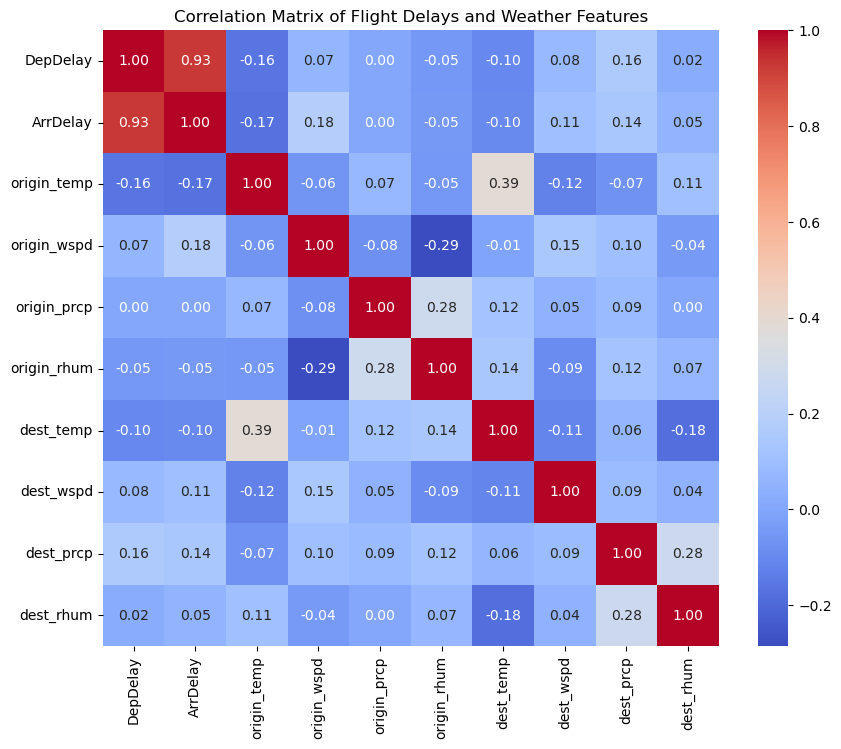

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have your sample pandas DataFrame as `sample_df`
plt.figure(figsize=(10, 8))
sns.heatmap(sample_df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Flight Delays and Weather Features")
plt.show()


# Observations
Windy conditions clearly dominate:

8 out of the top 10 delay-prone airports have is_windy = 1, shown in orange bars.

- Insights Summary:
Insight	Interpretation
Windy airports dominate delays - 80% of top delay-prone airports show wind as a key weather factor
Not all delays are weather-driven - Airports like HOB show that calm weather does not guarantee on-time departures



In [ ]:
final_df.createOrReplaceTempView("flight_delays")
summ = spark.sql("""
SELECT
  case when weatherdelay > 0 then 1 else 0 end AS weather_delay_indicator,
  Origin,
  Dest,
  CASE WHEN origin_wspd > 20 THEN 1 ELSE 0 END AS origin_windy,
  CASE WHEN dest_wspd > 20 THEN 1 ELSE 0 END AS dest_windy,
  CASE WHEN origin_prcp > 0 THEN 1 ELSE 0 END AS origin_rain,
  CASE WHEN dest_prcp > 0 THEN 1 ELSE 0 END AS dest_rain,
  COUNT(*) AS total_flights,
  SUM(case when ArrDelay>0 then 1 else 0 end) AS total_delayed_flights,
  sum(case when WeatherDelay>0 then 1 else 0 end) AS total_weather_delayed_flights,
  sum(DepDelay) AS total_dep_delay,
  sum(ArrDelay) AS total_arr_delay
  
FROM flight_delays
WHERE origin_rhum IS NOT NULL AND origin_rhum > 85
GROUP BY
  weather_delay_indicator, Origin, Dest,
  origin_windy, dest_windy,
  origin_rain, dest_rain""")

In [50]:
import pandas as pd

# Load data
summary_df = pd.read_csv("summary1.csv")

# Prepare two halves: one for origin, one for destination
origin_df = summary_df[['Origin', 'origin_windy', 'origin_rain', 'total_dep_delay', 'total_arr_delay', 'total_flights']].copy()
origin_df.columns = ['Airport', 'is_windy', 'is_rainy', 'dep_delay', 'arr_delay', 'flights']

dest_df = summary_df[['Dest', 'dest_windy', 'dest_rain', 'total_dep_delay', 'total_arr_delay', 'total_flights']].copy()
dest_df.columns = ['Airport', 'is_windy', 'is_rainy', 'dep_delay', 'arr_delay', 'flights']

# Combine origin and destination into one DataFrame
airport_weather_df = pd.concat([origin_df, dest_df])

# Group by weather conditions
combo_weather = (
    airport_weather_df
    .groupby(['is_windy', 'is_rainy'])[['dep_delay', 'arr_delay', 'flights']]
    .sum()
    .reset_index()
)

# Calculate average delays
combo_weather['avg_dep_delay'] = combo_weather['dep_delay'] / combo_weather['flights']
combo_weather['avg_arr_delay'] = combo_weather['arr_delay'] / combo_weather['flights']

# Keep only relevant columns for insights
combo_weather = combo_weather[['is_windy', 'is_rainy', 'avg_dep_delay', 'avg_arr_delay']]

# Show result
print(combo_weather)


   is_windy  is_rainy  avg_dep_delay  avg_arr_delay
0         0         0       9.499329       4.024227
1         0         1      18.780444      15.265161
2         1         0      15.888701      11.869961
3         1         1      25.643591      23.577360


In [52]:
import pandas as pd

# Load data
summary_df = pd.read_csv("summary1.csv")

# Combine origin and destination weather info
origin_df = summary_df[['Origin', 'origin_windy', 'origin_rain', 'total_dep_delay', 'total_arr_delay', 'total_flights']].copy()
origin_df.columns = ['Airport', 'is_windy', 'is_rainy', 'dep_delay', 'arr_delay', 'flights']

dest_df = summary_df[['Dest', 'dest_windy', 'dest_rain', 'total_dep_delay', 'total_arr_delay', 'total_flights']].copy()
dest_df.columns = ['Airport', 'is_windy', 'is_rainy', 'dep_delay', 'arr_delay', 'flights']

airport_weather_df = pd.concat([origin_df, dest_df])

# Classify weather condition type
def classify_weather(row):
    if row['is_windy'] == 1 and row['is_rainy'] == 1:
        return 'wind_and_rain'
    elif row['is_windy'] == 1:
        return 'wind_only'
    elif row['is_rainy'] == 1:
        return 'rain_only'
    else:
        return 'clear'

airport_weather_df['weather_type'] = airport_weather_df.apply(classify_weather, axis=1)

# Group by weather type and aggregate delays
weather_impact = (
    airport_weather_df
    .groupby('weather_type')[['dep_delay', 'arr_delay', 'flights']]
    .sum()
    .reset_index()
)

# Compute average delay per flight
weather_impact['avg_dep_delay'] = weather_impact['dep_delay'] / weather_impact['flights']
weather_impact['avg_arr_delay'] = weather_impact['arr_delay'] / weather_impact['flights']

# Show result
print(weather_impact[['weather_type', 'avg_dep_delay', 'avg_arr_delay', 'flights']])


    weather_type  avg_dep_delay  avg_arr_delay  flights
0          clear       9.499329       4.024227  2146491
1      rain_only      18.780444      15.265161   382039
2  wind_and_rain      25.643591      23.577360   108861
3      wind_only      15.888701      11.869961   245141


In [6]:
summary_df = spark.read.csv("hdfs:///user/ketkimaddiwar/summary_data/summary1.csv", header=True, inferSchema=True)
summary_df.show(5)
summary_df.printSchema()

+-----------------+------+----+-----+------------+----------+-----------+---------+-------------+---------------+---------------+
|Reporting_Airline|Origin|Dest|month|origin_windy|dest_windy|origin_rain|dest_rain|total_flights|total_dep_delay|total_arr_delay|
+-----------------+------+----+-----+------------+----------+-----------+---------+-------------+---------------+---------------+
|               WN|   IAH| BNA|    1|           0|         0|          0|        0|           19|          -85.0|         -227.0|
|               AA|   DAB| CLT|    1|           0|         0|          0|        0|           27|          146.0|          -91.0|
|               OH|   DAY| DCA|    1|           0|         0|          0|        0|           16|          -16.0|            0.0|
|               WN|   MCO| IAH|    1|           0|         0|          0|        0|            5|           51.0|           44.0|
|               DL|   TPA| MSP|    1|           0|         0|          0|        0|       

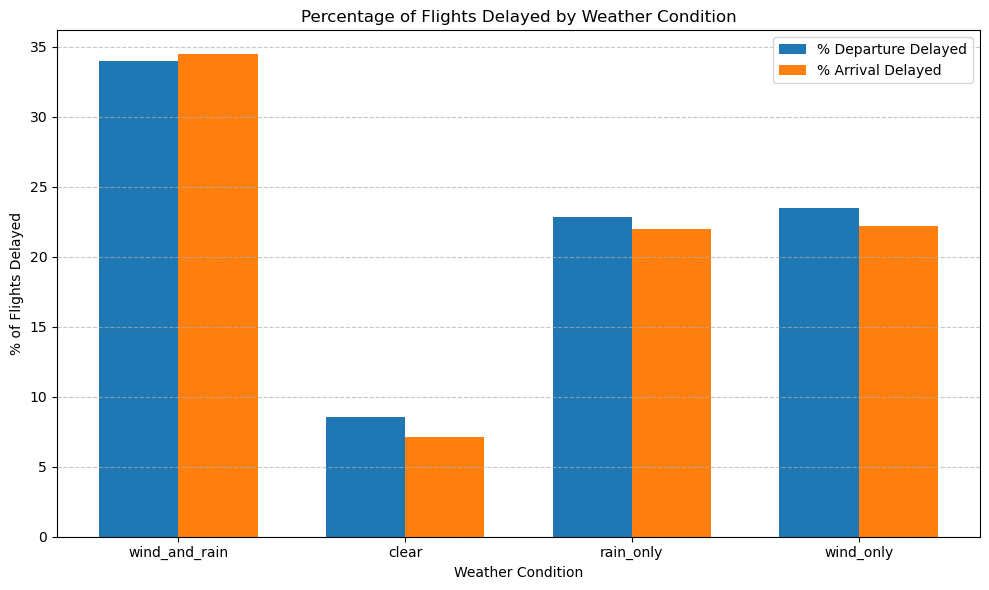

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, sum as _sum
import matplotlib.pyplot as plt

origin_df = summary_df.selectExpr(
    "Origin as Airport",
    "origin_windy as is_windy",
    "origin_rain as is_rainy",
    "total_dep_delay as dep_delay",
    "total_arr_delay as arr_delay",
    "total_flights as flights"
)

dest_df = summary_df.selectExpr(
    "Dest as Airport",
    "dest_windy as is_windy",
    "dest_rain as is_rainy",
    "total_dep_delay as dep_delay",
    "total_arr_delay as arr_delay",
    "total_flights as flights"
)

combined_df = origin_df.union(dest_df)

combined_df = combined_df.withColumn(
    "weather_type",
    when((col("is_windy") == 1) & (col("is_rainy") == 1), "wind_and_rain")
    .when((col("is_windy") == 1), "wind_only")
    .when((col("is_rainy") == 1), "rain_only")
    .otherwise("clear")
)

combined_df = combined_df.withColumn("dep_delayed_flag", (col("dep_delay") > 0).cast("int"))
combined_df = combined_df.withColumn("arr_delayed_flag", (col("arr_delay") > 0).cast("int"))

delay_stats_spark = combined_df.groupBy("weather_type").agg(
    _sum("dep_delayed_flag").alias("dep_delayed_count"),
    _sum("arr_delayed_flag").alias("arr_delayed_count"),
    _sum("flights").alias("total_flights")
)

delay_stats_spark = delay_stats_spark.withColumn(
    "pct_dep_delayed", (col("dep_delayed_count") / col("total_flights")) * 100
).withColumn(
    "pct_arr_delayed", (col("arr_delayed_count") / col("total_flights")) * 100
)

delay_stats = delay_stats_spark.toPandas()

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(delay_stats))

plt.bar(x, delay_stats['pct_dep_delayed'], width=bar_width, label='% Departure Delayed')
plt.bar([p + bar_width for p in x], delay_stats['pct_arr_delayed'], width=bar_width, label='% Arrival Delayed')

plt.xlabel('Weather Condition')
plt.ylabel('% of Flights Delayed')
plt.title('Percentage of Flights Delayed by Weather Condition')
plt.xticks([p + bar_width/2 for p in x], delay_stats['weather_type'])
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

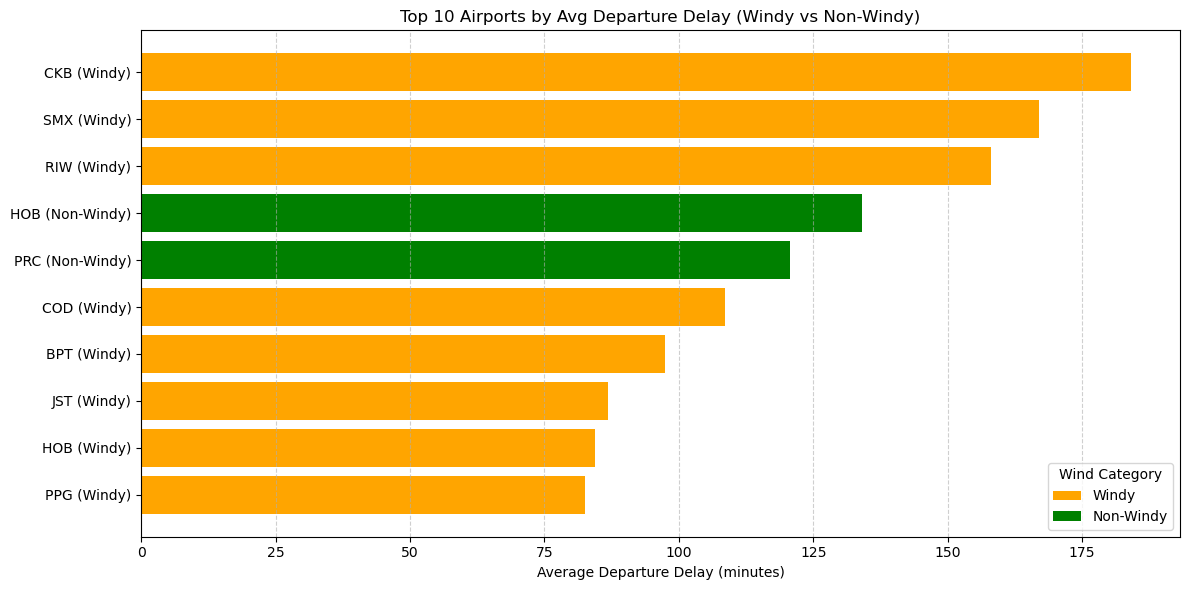

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, when
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


df = spark.read.csv("hdfs:///user/ketkimaddiwar/summary_data/summary1.csv", header=True, inferSchema=True)

origin_df = df.selectExpr(
    "Origin as Airport",
    "origin_windy as is_windy",
    "total_dep_delay as dep_delay",
    "total_flights as flights"
)

dest_df = df.selectExpr(
    "Dest as Airport",
    "dest_windy as is_windy",
    "total_dep_delay as dep_delay",
    "total_flights as flights"
)

combined_df = origin_df.union(dest_df)

grouped = combined_df.groupBy("Airport", "is_windy").agg(
    _sum("dep_delay").alias("dep_delay"),
    _sum("flights").alias("flights")
)

grouped = grouped.withColumn("avg_dep_delay", col("dep_delay") / col("flights"))

grouped = grouped.withColumn(
    "wind_category",
    when(col("is_windy") == 1, "Windy").otherwise("Non-Windy")
)

top10_pd = grouped.orderBy(col("avg_dep_delay").desc()).limit(10).toPandas()
top10_pd['label'] = top10_pd['Airport'] + ' (' + top10_pd['wind_category'] + ')'

color_map = {"Windy": "orange", "Non-Windy": "green"}
top10_pd['color'] = top10_pd['wind_category'].map(color_map)

plt.figure(figsize=(12, 6))
plt.barh(top10_pd['label'], top10_pd['avg_dep_delay'], color=top10_pd['color'])
plt.xlabel('Average Departure Delay (minutes)')
plt.title('Top 10 Airports by Avg Departure Delay (Windy vs Non-Windy)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

legend_elements = [Patch(facecolor=color_map[k], label=k) for k in color_map]
plt.legend(handles=legend_elements, title="Wind Category")

plt.show()


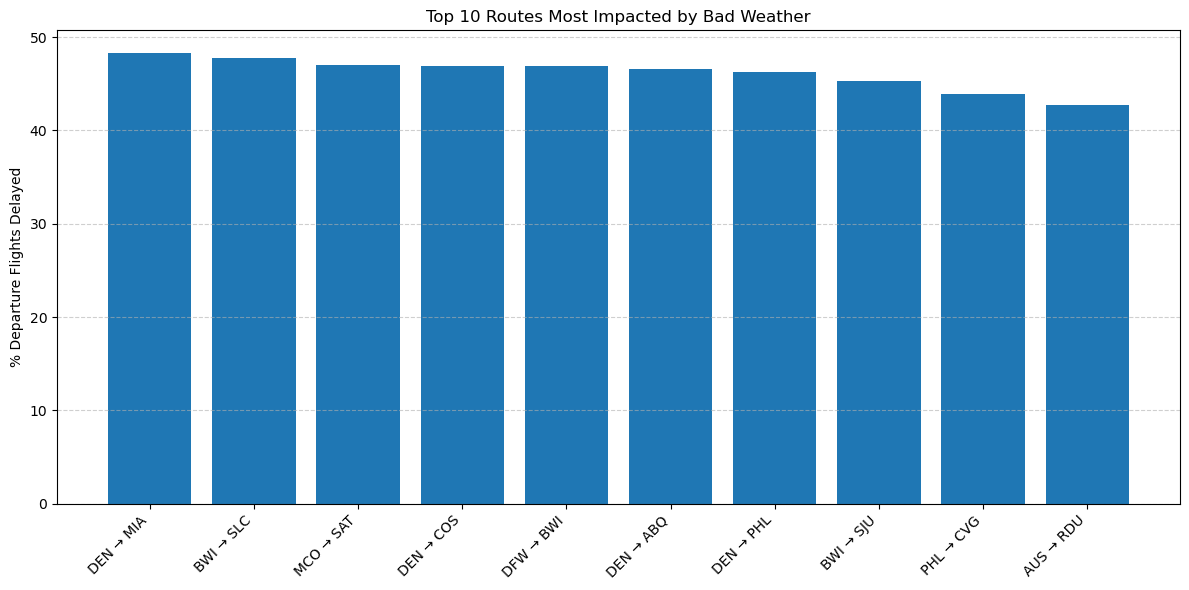

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, expr, concat_ws
import matplotlib.pyplot as plt

df = spark.read.csv("hdfs:///user/ketkimaddiwar/summary_data/summary1.csv", header=True, inferSchema=True)

df = df.withColumn("weather_type", when((col("origin_windy") == 1) & (col("origin_rain") == 1) |
                                        (col("dest_windy") == 1) & (col("dest_rain") == 1), "wind_and_rain")
    .when((col("origin_windy") == 1) | (col("dest_windy") == 1), "wind_only")
    .when((col("origin_rain") == 1) | (col("dest_rain") == 1), "rain_only")
    .otherwise("clear"))

df = df.withColumn("is_bad_weather", (col("weather_type") != "clear").cast("boolean"))

df = df.withColumn("dep_delayed_flag", (col("total_dep_delay") > 0).cast("int"))

df = df.withColumn("Route", concat_ws(" → ", col("Origin"), col("Dest")))

bad_weather_df = df.filter(col("is_bad_weather") == True)

route_stats = bad_weather_df.groupBy("Route").agg(
    expr("sum(dep_delayed_flag)").alias("dep_delayed_count"),
    expr("sum(total_flights)").alias("total_flights")
)

route_stats = route_stats.withColumn("pct_dep_delayed", 
                                     (col("dep_delayed_count") / col("total_flights")) * 100)

route_stats = route_stats.filter(col("total_flights") >= 100)

top10_routes = route_stats.orderBy(col("pct_dep_delayed").desc()).limit(10).toPandas()

plt.figure(figsize=(12, 6))
plt.bar(top10_routes['Route'], top10_routes['pct_dep_delayed'])
plt.ylabel('% Departure Flights Delayed')
plt.title('Top 10 Routes Most Impacted by Bad Weather')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
